In [10]:
import itertools as it
import json
import os
from pathlib import Path

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import seaborn.objects as so
from scipy.interpolate import interp1d
from stamox.sample import bootstrap

from jackpot.utils.random import EasyKey

# Force usage of CPU in this notebook only
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_platforms", "cpu")

# CPU cores as separate devices
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

k = EasyKey(seed=1234)

In [11]:
root = (Path() / "..").resolve()
display(root)

experiment_path = root / "experiments" / "measure_2D"

PosixPath('/home/jeppe/JaxIsingModel')

In [12]:
# Load measurements
meas_df = pd.DataFrame()
for experiment in experiment_path.glob("*"):
    if not experiment.is_dir():
        continue

    with open(experiment / "config.json") as f:
        config = json.load(f)

    _meas_df = pd.read_feather(experiment / "meas_df.feather")
    _meas_df["size"] = config["size"]
    _meas_df["dimensions"] = config["dimensions"]
    _meas_df["algorithm"] = config["algorithm"]

    meas_df = pd.concat([meas_df, _meas_df])

In [13]:
# DataFrame to store observations in
obs_df = pd.DataFrame()

meas_df["energy_dens"] = meas_df["energy"] / meas_df["size"] ** meas_df["dimensions"]
meas_df["mag_dens"] = meas_df["magnetisation_density"]
meas_df["abs_mag_dens"] = meas_df["abs_magnetisation_density"]

meas_df["temp"] = meas_df["natural_temperature"]


def find_bootstrap_var_sem(data):
    """
    Finds the Standard Error of the variance using bootstrapping.
    This is accelerated across all available CPU cores and is quite slow.
    """
    keys = k.shaped((jax.device_count(),))
    p_bootstrap = eqx.filter_pmap(bootstrap, in_axes=(None, None, None, 0))

    bootstraps = p_bootstrap(jnp.asarray(data), jnp.var, 64, keys)

    sem = scipy.stats.sem(bootstraps.flatten())
    return sem


# Group by temperatures and size
temp_group = meas_df.groupby(["temp", "size"])

obs_df["dimensions"] = temp_group["dimensions"].first()

obs_df["energy_dens_mean"] = temp_group["energy_dens"].mean()
obs_df["energy_dens_var"] = temp_group["energy_dens"].var()
obs_df["energy_dens_sem"] = temp_group["energy_dens"].sem()
obs_df["energy_dens_mean_min"] = obs_df["energy_dens_mean"] - obs_df["energy_dens_sem"]
obs_df["energy_dens_mean_max"] = obs_df["energy_dens_mean"] + obs_df["energy_dens_sem"]
obs_df["energy_dens_var_sem"] = temp_group["energy_dens"].apply(find_bootstrap_var_sem)

obs_df["abs_mag_dens_mean"] = temp_group["abs_mag_dens"].mean()
obs_df["abs_mag_dens_var"] = temp_group["abs_mag_dens"].var()
obs_df["abs_mag_dens_sem"] = temp_group["abs_mag_dens"].sem()
obs_df["abs_mag_dens_mean_min"] = (
    obs_df["abs_mag_dens_mean"] - obs_df["abs_mag_dens_sem"]
)
obs_df["abs_mag_dens_mean_max"] = (
    obs_df["abs_mag_dens_mean"] + obs_df["abs_mag_dens_sem"]
)
obs_df["abs_mag_dens_var_sem"] = temp_group["abs_mag_dens"].apply(
    find_bootstrap_var_sem
)

obs_df = obs_df.reset_index()

<Figure size 640x480 with 0 Axes>

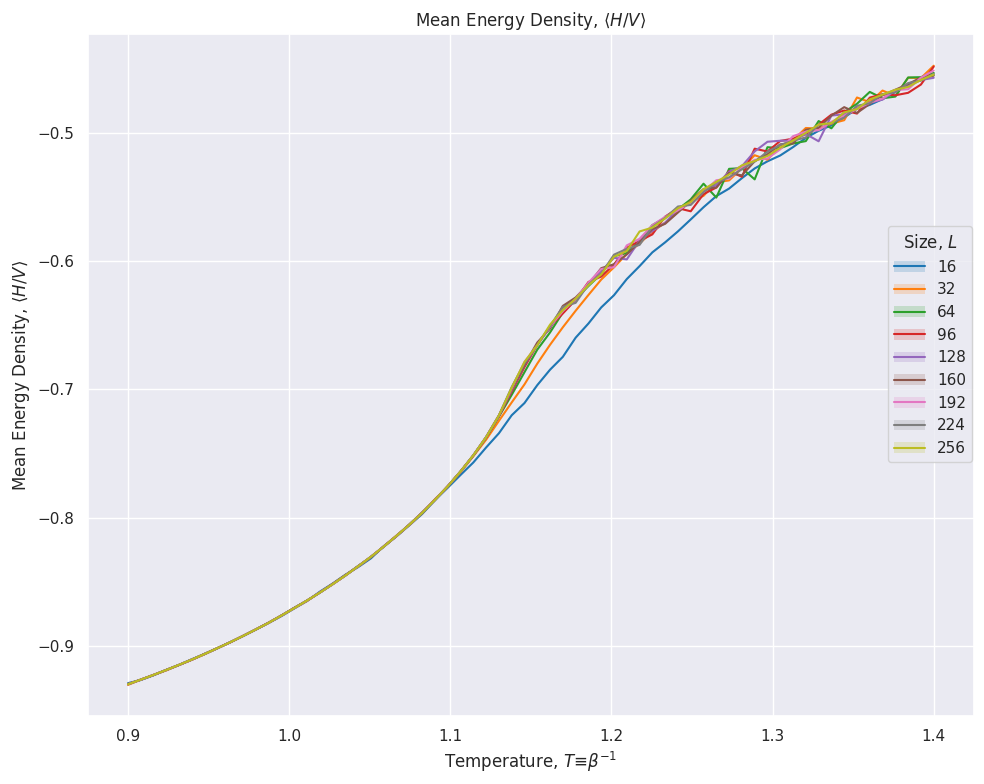

<Figure size 640x480 with 0 Axes>

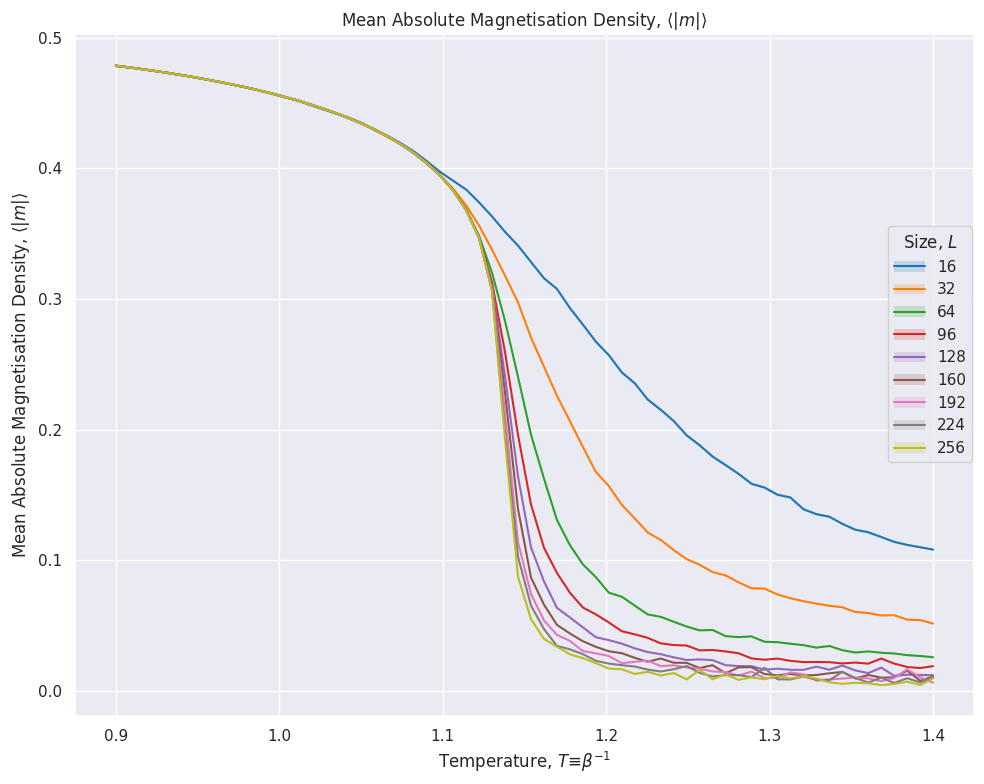

In [14]:
# Plot energy density and magnetisation density
def plot_obs(obs_df: pd.DataFrame, obs_name: str, obs_label: str, on: None = None):
    has_errors = f"{obs_name}_min" in obs_df.columns
    ymin = None
    ymax = None
    if has_errors:
        ymin = f"{obs_name}_min"
        ymax = f"{obs_name}_max"

    plot = (
        so.Plot(
            data=obs_df,
            x="temp",
            y=obs_name,
            ymin=ymin,
            ymax=ymax,
            color="size",
        )
        .scale(color="tab10")
        .add(so.Line())
        .theme({"figure.figsize": (10, 8)})
        .label(
            x="Temperature, $T ≡ β^{-1}$",
            y=obs_label,
            color="Size, $L$",
            title=f"{obs_label}",
        )
    )

    if has_errors:
        plot = plot.add(so.Band())

    if on is not None:
        plot = plot.on(on)

    return plot


plt.figure()
plot_obs(
    obs_df, "energy_dens_mean", r"Mean Energy Density, $\langle H/V\rangle$"
).show()
plt.figure()
plot_obs(
    obs_df,
    "abs_mag_dens_mean",
    r"Mean Absolute Magnetisation Density, $\langle |m|\rangle$",
).show()

<Figure size 640x480 with 0 Axes>

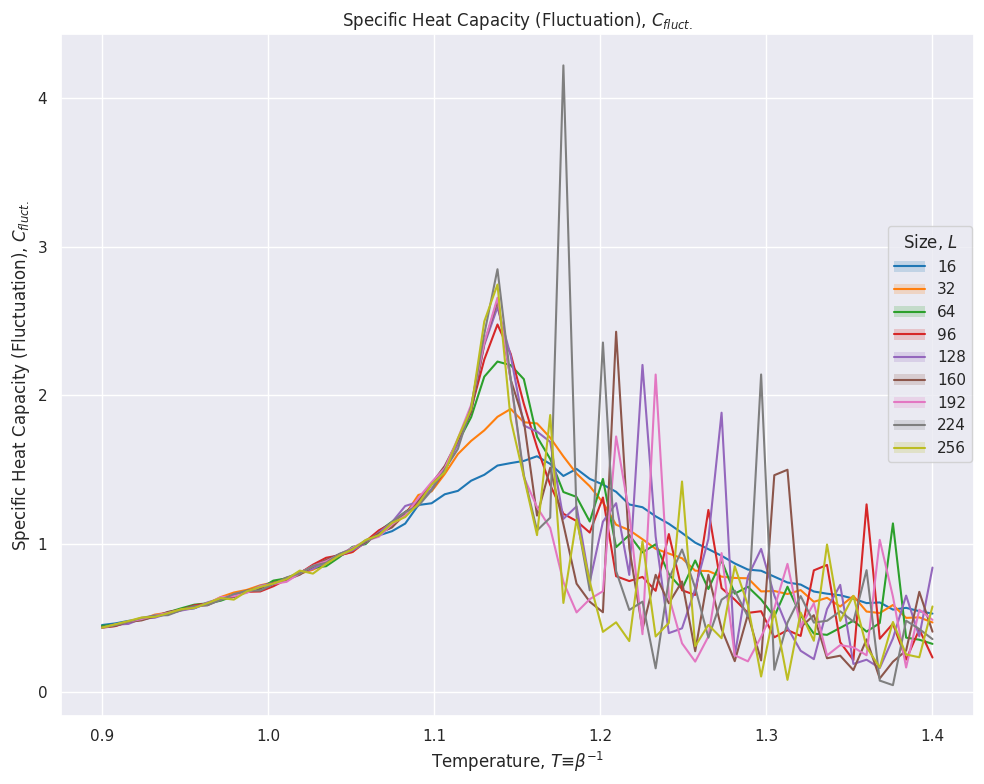

<Figure size 640x480 with 0 Axes>

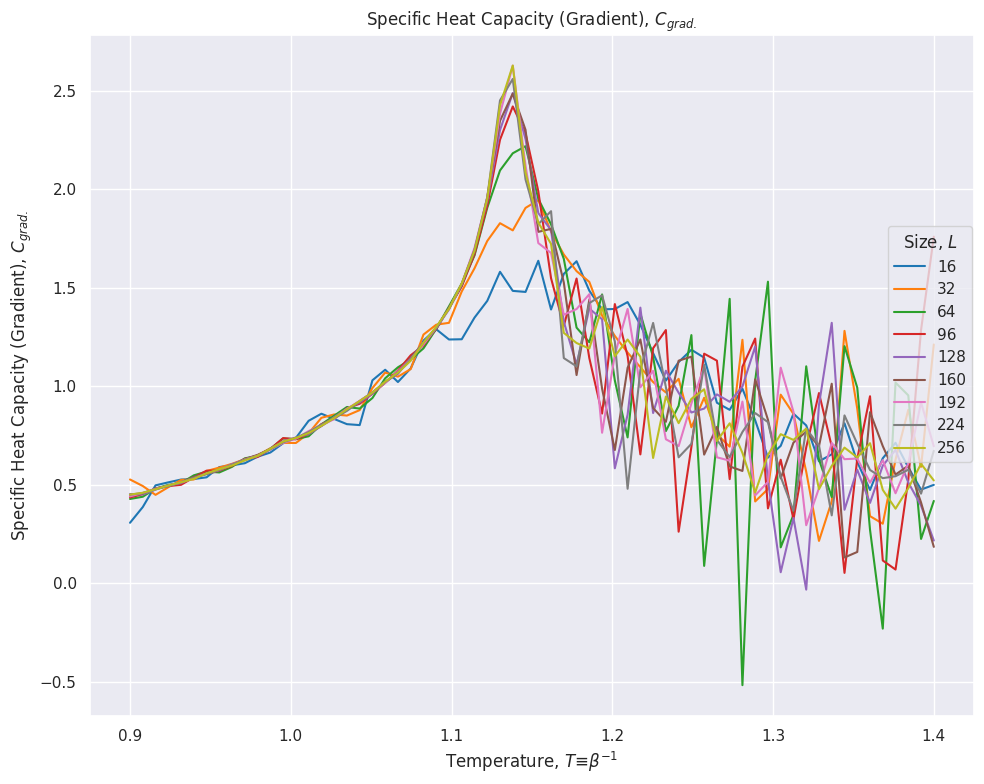

In [15]:
# Heat Capacity
obs_df["specific_heat_cap_fluctuation"] = (
    obs_df["energy_dens_var"] / (np.square(obs_df["temp"])) * obs_df["size"] ** obs_df["dimensions"]
)
obs_df["specific_heat_cap_fluctuation_sem"] = (
    obs_df["energy_dens_var_sem"] / (np.square(obs_df["temp"])) * obs_df["size"] ** obs_df["dimensions"]
)
obs_df["specific_heat_cap_fluctuation_min"] = (
    obs_df["specific_heat_cap_fluctuation"]
    - obs_df["specific_heat_cap_fluctuation_sem"]
)
obs_df["specific_heat_cap_fluctuation_max"] = (
    obs_df["specific_heat_cap_fluctuation"]
    + obs_df["specific_heat_cap_fluctuation_sem"]
)


def specific_heat_cap_gradient(group):
    grad = np.gradient(group["energy_dens_mean"], group["temp"])
    group["specific_heat_cap_gradient"] = grad
    return group


obs_df = obs_df.groupby("size", as_index=False).apply(specific_heat_cap_gradient)

plt.figure()
plot_obs(
    obs_df,
    "specific_heat_cap_fluctuation",
    r"Specific Heat Capacity (Fluctuation), $C_{fluct.}$",
).show()

plt.figure()
plot_obs(
    obs_df,
    "specific_heat_cap_gradient",
    r"Specific Heat Capacity (Gradient), $C_{grad.}$",
).show()

<Figure size 640x480 with 0 Axes>

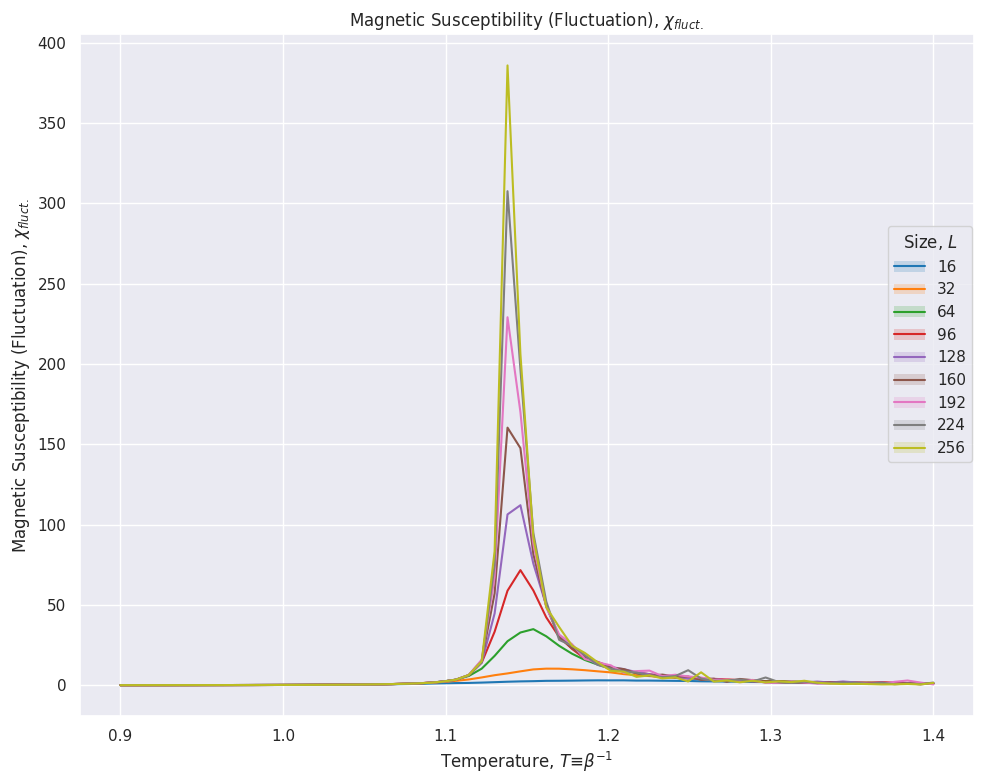

<Figure size 640x480 with 0 Axes>

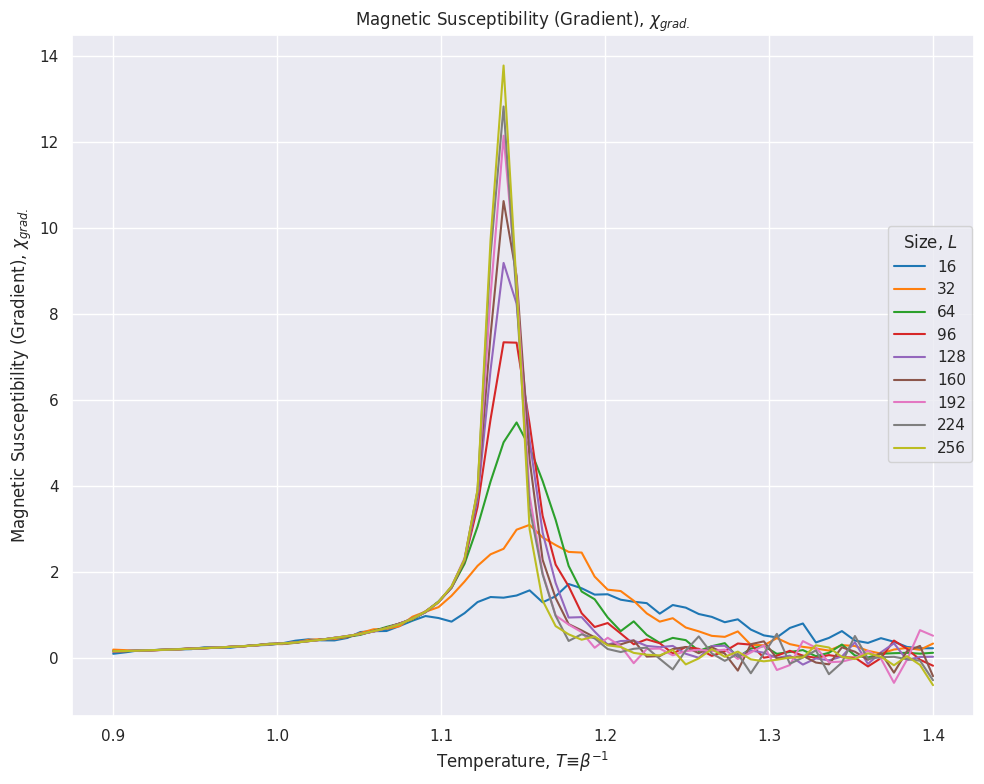

In [16]:
# Magnetic Susceptibility
obs_df["mag_sus_fluctuation"] = (
    obs_df["size"] ** obs_df["dimensions"] * obs_df["abs_mag_dens_var"] / obs_df["temp"]
)
obs_df["mag_sus_fluctuation_sem"] = (
    obs_df["size"] ** obs_df["dimensions"] * obs_df["abs_mag_dens_var_sem"] / obs_df["temp"]
)
obs_df["mag_sus_fluctuation_min"] = (
    obs_df["mag_sus_fluctuation"] - obs_df["mag_sus_fluctuation_sem"]
)
obs_df["mag_sus_fluctuation_max"] = (
    obs_df["mag_sus_fluctuation"] + obs_df["mag_sus_fluctuation_sem"]
)


def mag_sus_gradient(group):
    grad = np.gradient(group["abs_mag_dens_mean"], group["temp"])
    group["mag_sus_gradient"] = -grad
    return group


obs_df = obs_df.groupby("size", as_index=False).apply(mag_sus_gradient)

plt.figure()
plot_obs(
    obs_df,
    "mag_sus_fluctuation",
    r"Magnetic Susceptibility (Fluctuation), $χ_{fluct.}$",
).show()
plt.figure()
plot_obs(
    obs_df,
    "mag_sus_gradient",
    r"Magnetic Susceptibility (Gradient), $χ_{grad.}$",
).show()

<Figure size 640x480 with 0 Axes>

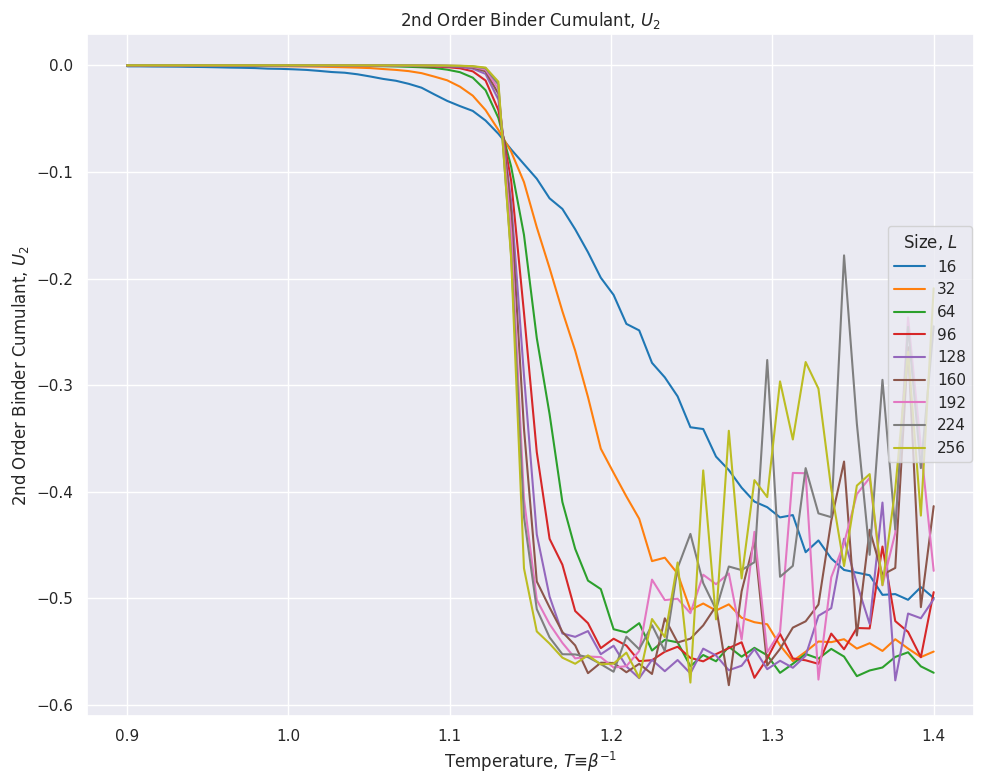

<Figure size 640x480 with 0 Axes>

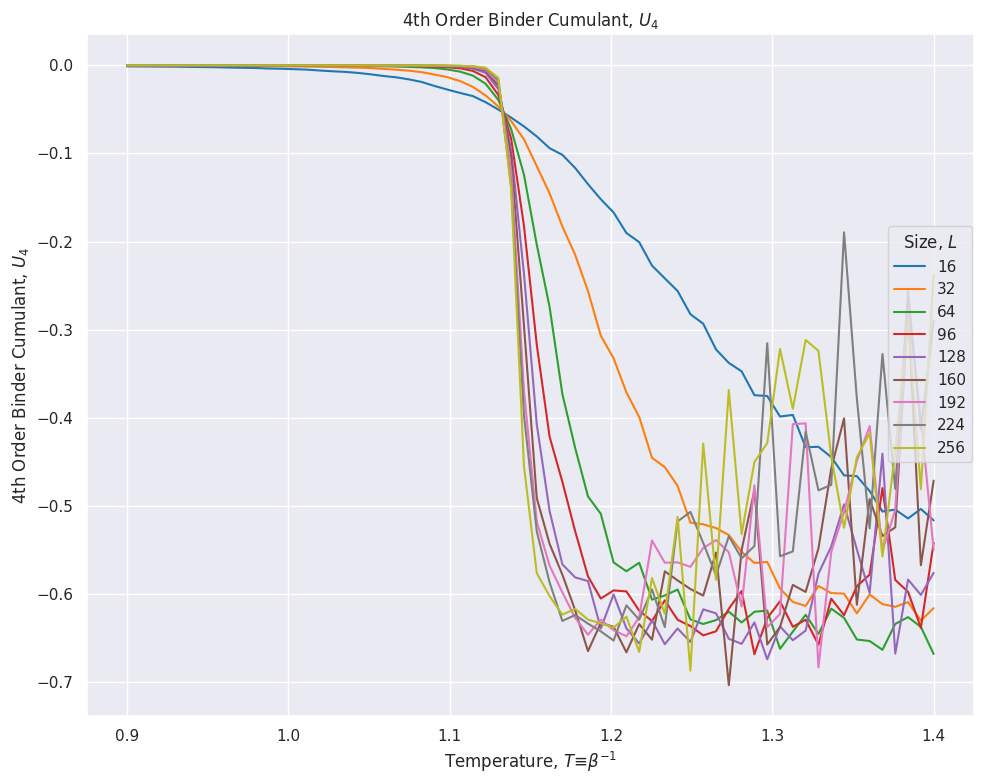

In [17]:
# Binder cumulants
meas_df["mag_1"] = np.abs(meas_df["magnetisation_density"])
meas_df["mag_2"] = np.power(meas_df["magnetisation_density"], 2)
meas_df["mag_4"] = np.power(meas_df["magnetisation_density"], 4)

state_group = meas_df.groupby(["temp", "size", "state_id"])

binder_df = pd.DataFrame()
binder_df["mag_1_mean"] = state_group["mag_1"].mean()
binder_df["mag_2_mean"] = state_group["mag_2"].mean()
binder_df["mag_4_mean"] = state_group["mag_4"].mean()

binder_df["mag_1_sem"] = state_group["mag_1"].sem()
binder_df["mag_2_sem"] = state_group["mag_2"].sem()
binder_df["mag_4_sem"] = state_group["mag_4"].sem()

from uncertainties import unumpy as unp

binder_df["mag_1_mean_sem"] = unp.uarray(
    binder_df["mag_1_mean"], binder_df["mag_1_sem"]
)
binder_df["mag_2_mean_sem"] = unp.uarray(
    binder_df["mag_2_mean"], binder_df["mag_2_sem"]
)
binder_df["mag_4_mean_sem"] = unp.uarray(
    binder_df["mag_4_mean"], binder_df["mag_4_sem"]
)

binder_df["binder_2_mean_sem"] = 1 - binder_df["mag_2_mean_sem"] / np.square(
    binder_df["mag_1_mean_sem"]
)
binder_df["binder_4_mean_sem"] = 1.0 / 3.0 - binder_df["mag_4_mean_sem"] / (
    3.0 * np.square(binder_df["mag_2_mean_sem"])
)

binder_df = binder_df.reset_index()

binder_summary_df = pd.DataFrame()
binder_summary_df["binder_2_mean_sem"] = binder_df.groupby(["temp", "size"])[
    "binder_2_mean_sem"
].apply(lambda x: np.sum(x) / len(x))
binder_summary_df["binder_2_mean"] = unp.nominal_values(
    binder_summary_df["binder_2_mean_sem"]
)
binder_summary_df["binder_2_sem"] = unp.std_devs(binder_summary_df["binder_2_mean_sem"])
binder_summary_df["binder_2_min"] = (
    binder_summary_df["binder_2_mean"] - binder_summary_df["binder_2_sem"]
)
binder_summary_df["binder_2_max"] = (
    binder_summary_df["binder_2_mean"] + binder_summary_df["binder_2_sem"]
)
binder_summary_df["binder_4_mean_sem"] = binder_df.groupby(["temp", "size"])[
    "binder_4_mean_sem"
].apply(lambda x: np.sum(x) / len(x))
binder_summary_df["binder_4_mean"] = unp.nominal_values(
    binder_summary_df["binder_4_mean_sem"]
)
binder_summary_df["binder_4_sem"] = unp.std_devs(binder_summary_df["binder_4_mean_sem"])
binder_summary_df["binder_4_min"] = (
    binder_summary_df["binder_4_mean"] - binder_summary_df["binder_4_sem"]
)
binder_summary_df["binder_4_max"] = (
    binder_summary_df["binder_4_mean"] + binder_summary_df["binder_4_sem"]
)

binder_summary_df = binder_summary_df.reset_index()
obs_df = pd.merge(obs_df, binder_summary_df, on=["size", "temp"], validate="1:1")

plt.figure()
plot_obs(
    obs_df,
    "binder_2_mean",
    r"2nd Order Binder Cumulant, $U_2$",
).show()

plt.figure()
plot_obs(
    obs_df,
    "binder_4_mean",
    r"4th Order Binder Cumulant, $U_4$",
).show()

In [18]:
# Save data
save_df = obs_df.drop(["binder_2_mean_sem", "binder_4_mean_sem"], axis="columns")
save_df.to_feather(experiment_path / "observation_summary.feather")

In [19]:
# Find crossings
from scipy import optimize


# Set up interpolations
def get_interp(group):
    return interp1d(
        group["temp"],
        group["binder_4_mean"],
        kind="linear",
        # fill_value="extrapolate",
    )


match obs_df["dimensions"].iloc[0]:
    case 2:
        temp_q = "1.00 <= temp <= 1.25"
        solver_bracket = (1.1, 1.15)
        solver_x0 = 1.13
        solver_x1 = 1.14
    case 3:
        temp_q = "dimensions == 3"  # Select all
        solver_bracket = (2.25, 2.26)
        # solver_bracket = None
        solver_x0 = 2.250
        solver_x1 = 2.255
    case _:
        assert False

interps = obs_df.query(temp_q).groupby("size").apply(get_interp).tolist()

crossings = []
for interp1, interp2 in it.combinations(interps, 2):
    difference = lambda x: interp1(x) - interp2(x)
    root_sol = optimize.root_scalar(
        difference, x0=solver_x0, x1=solver_x1, bracket=solver_bracket
    )
    # assert root_sol.converged

    crossings.append(root_sol.root)

T_c = np.mean(crossings)
T_c_sd = np.std(crossings)

print(f"{T_c}±{T_c_sd}")
print(1 / (1 * np.log(1 + np.sqrt(2))))


1.1326005279325906±0.0006615898643354854
1.134592657106511


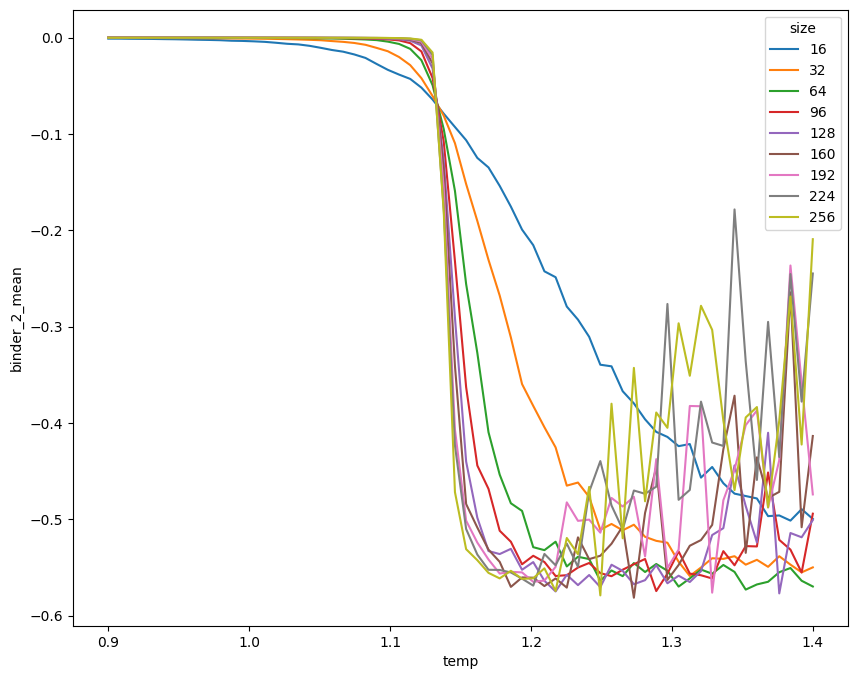

In [20]:
fig = plt.figure()
fig.set_size_inches(10, 8)
ax = sns.lineplot(
    data=obs_df,
    x="temp",
    y="binder_2_mean",
    hue="size",
    palette="tab10",
)
# ax.set(xlim=(1.0, 1.2), ylim=(-0.1, 0.01))